In [7]:
import sys
import os
import pandas as pd
import numpy as np

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier

from quant.Classification import Classification
from quant.factor import get_factors

import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

np.set_printoptions(precision=4, suppress=True)

import warnings
warnings.filterwarnings('ignore')

In [8]:
klines_1h_file = 'data/futures_klines_1h_BTCUSDT_20200101_20220430.zip'
kline_1h_df = pd.read_csv(klines_1h_file, index_col=0, parse_dates=True)
kline_1h_factors = get_factors(kline_1h_df, sign_ratio=1)

In [9]:
X = kline_1h_factors.drop(['Price', 'Returns', 'CumReturns', 'Log_Returns', 'Returns_Ratio', 'Sign'], axis=1)
y = kline_1h_factors['Sign']
X.shape, y.shape

((20217, 18), (20217,))

In [12]:
pca = PCA(n_components='mle', svd_solver="full")
pca.fit(X)
print(pca.explained_variance_ratio_)

pca = PCA(n_components=8, svd_solver="full")
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)

[0.9735 0.0204 0.0044 0.0009 0.0004 0.0002 0.0001 0.0001 0.     0.
 0.     0.     0.     0.     0.     0.     0.    ]
[0.9735 0.0204 0.0044 0.0009 0.0004 0.0002 0.0001 0.0001]


#### Post pruning decision trees with cost complexity pruning

https://scikit-learn.org/stable/auto_examples/tree/plot_cost_complexity_pruning.html#sphx-glr-auto-examples-tree-plot-cost-complexity-pruning-py

Text(0.5, 1.0, 'Total Impurity vs Effective alpha for training set')

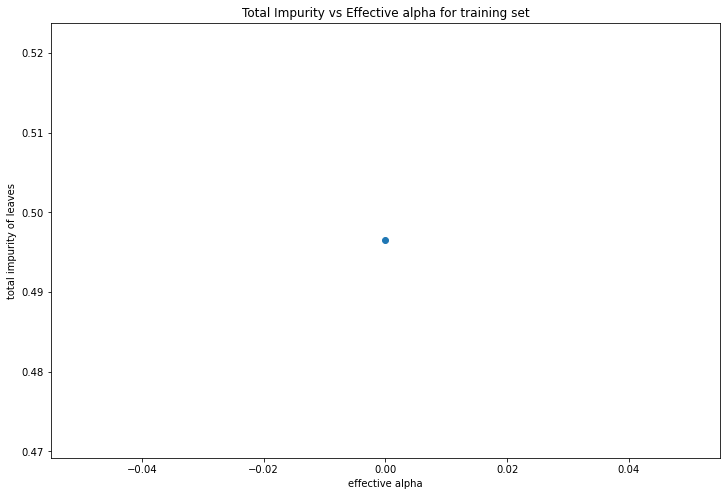

In [32]:
# Post Pruning

clf = DecisionTreeClassifier(criterion='gini',
                             max_depth=1,
                             max_features=6,
                             min_samples_leaf=1,
                             min_samples_split=2,
                             random_state=64)
path = clf.cost_complexity_pruning_path(X, y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs Effective alpha for training set")

In [33]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(criterion='gini',
                                 max_depth=1,
                                 max_features=6,
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 random_state=64,
                                 ccp_alpha=ccp_alpha)
    clf.fit(X, y)
    clfs.append(clf)
print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(clfs[-1].tree_.node_count, ccp_alphas[-1]))

Number of nodes in the last tree is: 1 with ccp_alpha: 0.0032431357236767933


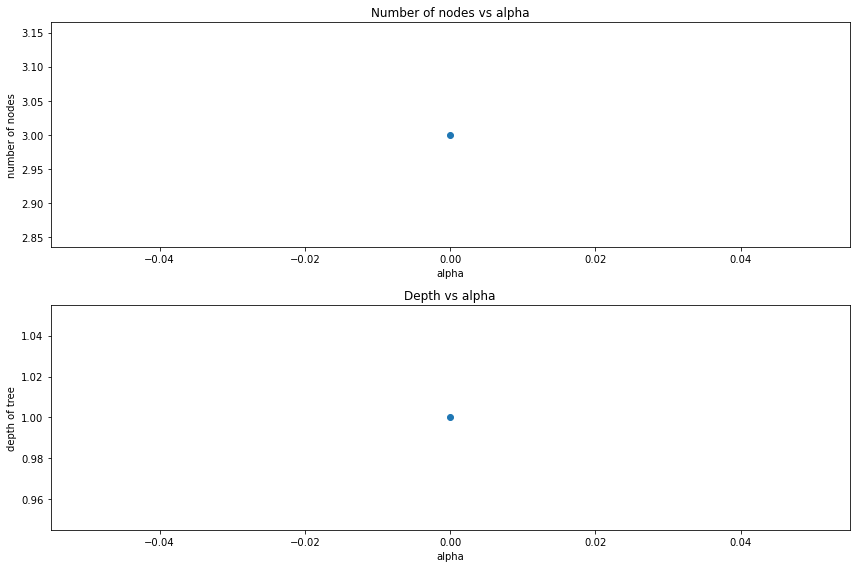

In [34]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [36]:
dt = Classification(X, y)
dt.fit_predict(MinMaxScaler(), DecisionTreeClassifier(random_state=64))
mse, rmse, r2train, r2test = dt.eval_metrics()
mse, rmse, r2train, r2test

(0.49455984174085066, 0.7032494875510757, 1.0, 0.5054401582591493)

In [37]:
dt_best = Classification(X, y)
dt_best.fit_predict(
    MinMaxScaler(),
    DecisionTreeClassifier(criterion='gini',
                           max_depth=1,
                           max_features=6,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           random_state=64,
                           ccp_alpha=0))
best_mse, best_rmse, best_r2train, best_r2test = dt_best.eval_metrics()
best_mse, best_rmse, best_r2train, best_r2test


(0.4710682492581602,
 0.6863441186884027,
 0.5397267050021641,
 0.5289317507418397)

In [40]:
dt_pca = Classification(X_pca, y)
dt_pca.fit_predict(MinMaxScaler(), DecisionTreeClassifier(random_state=64))
pca_mse, pca_rmse, pca_r2train, pca_r2test = dt_pca.eval_metrics()
pca_mse, pca_rmse, pca_r2train, pca_r2test

(0.4950544015825915, 0.703601024432591, 1.0, 0.5049455984174085)

In [41]:
dt_best_pca = Classification(X_pca, y)
dt_best_pca.fit_predict(
    MinMaxScaler(),
    DecisionTreeClassifier(criterion='gini',
                           max_depth=1,
                           max_features=6,
                           min_samples_leaf=1,
                           min_samples_split=2,
                           random_state=64,
                           ccp_alpha=0))
best_pca_mse, best_pca_rmse, best_pca_r2train, best_pca_r2test = dt_best_pca.eval_metrics()
best_pca_mse, best_pca_rmse, best_pca_r2train, best_pca_r2test


(0.49332344213649854,
 0.7023698755901328,
 0.5224138997093922,
 0.5066765578635015)

In [42]:
# PCA Result
pd.set_option('display.float_format', lambda x: '%.8f' % x)
pca_result = pd.DataFrame()
pca_result = pca_result.append([['Original Factors', mse, rmse, r2train, r2test]])
pca_result = pca_result.append([['Original Factors with Pruning', best_mse, best_rmse, best_r2train, best_r2test]])

pca_result = pca_result.append([['PCA Factors', pca_mse, pca_rmse, pca_r2train, pca_r2test]])
pca_result = pca_result.append([['PCA Factors with Pruning', best_pca_mse, best_pca_rmse, best_pca_r2train, best_pca_r2test]])

pca_result.columns = ['', 'MSE', 'RMSE', 'R2Train', 'R2Test']
pca_result.reset_index(drop=True, inplace=True)
print(pca_result.to_latex(index=False))
pca_result

\begin{tabular}{lrrrr}
\toprule
                              &        MSE &       RMSE &    R2Train &     R2Test \\
\midrule
             Original Factors & 0.49455984 & 0.70324949 & 1.00000000 & 0.50544016 \\
Original Factors with Pruning & 0.47106825 & 0.68634412 & 0.53972671 & 0.52893175 \\
                  PCA Factors & 0.49505440 & 0.70360102 & 1.00000000 & 0.50494560 \\
     PCA Factors with Pruning & 0.49332344 & 0.70236988 & 0.52241390 & 0.50667656 \\
\bottomrule
\end{tabular}



,,MSE,RMSE,R2Train,R2Test
0,Original Factors,0.49455984,0.70324949,1.00000000,0.50544016
1,Original Factors with Pruning,0.47106825,0.68634412,0.53972671,0.52893175
2,PCA Factors,0.49505440,0.70360102,1.00000000,0.50494560
3,PCA Factors with Pruning,0.49332344,0.70236988,0.52241390,0.50667656


#### Conclusion

From the result table, Pruning works. After Pruning, MSE of Original Factors decreases from 0.49 to 0.47 and MSE of PCA Factors decreases from 0.4950 to 0.4933. R2Test Score of Original Factors increases from 0.50 to 0.53 and R2Test Score of PCA Factors increases from 0.5049 to 0.5067. Obviously, Pruning plays a greater role in big data sets.